## Classifying handwritten digits with a CNN


In the previous exercies, we worked with fully-connected neural networks, which are good at handling tabular data, where the inputs and targets are easily presented as vectors.

However, in the case of images, or image-like objects, such models are less efficient for reasons we have discussed in the slides. When inputs are images, or image-like data, a more natural choice of model is a convolution neural network—in particularly, a model which uses 2D convolutional layers.

Before we start worrying about choosing models, let's first acquaint ourselves with the MNIST data.

The first step is to select a directory for the data to live.

In [90]:
mnist_root = "mnist-data/"

If we all set a path this way it will help to maintain consistency throughout this exercise.

### Task 1: Access the MNIST dataset.

PyTorch has a (sort of) sister Python library for dealing with images: [``Torchvision``](https://pytorch.org/vision/stable/index.html) (take a look at the website for a few minutes).

In the previous exercies, we used a custom ``Dataset`` object created specifically for this event, but with ``Torchvision`` comes a bunch of easy-to-use datasets, one of which is MNIST.

- Look at the arguments of the MNIST datset: what options do we have?
- Instantiate the (training) dataset.
- Iterate over it: how are the inputs and targets presented to us?
- Plot some images, and set their targets as the title, to make sure the data make sense.

Note: this section might prove a bit tricky for many people, so I will go through it first.

In [91]:
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt

data_set = MNIST(root=mnist_root, download=True)



### Task 2

As before, we have a dataset which gives us inputs and targets, but we still need to convert the data to ``torch.Tensors``

#### Part (a) — raw data to ``Tensor``s

Let's do this basic steps first: supply transforms to map between the raw data and ``torch.Tensors``.



#### Part (b) — fun with data augmentation

Additionally, with image data there are some other consideration we might make:
- Are CNNs rotationally invariant?
  - If we want out model still to work on images which are not of a regular orientation, we must use random rotations as a form of augmentation.
- If we train a model on purely black-and-white images, how will it fare on more colourful data?
- Go to ``Torchvision``'s [transforms](https://pytorch.org/vision/stable/transforms.html) and look at the the available forms of images augmentation.
  - Take a few minutes to pick ones you think might be relevant.
  - Let's discuss and choose some.

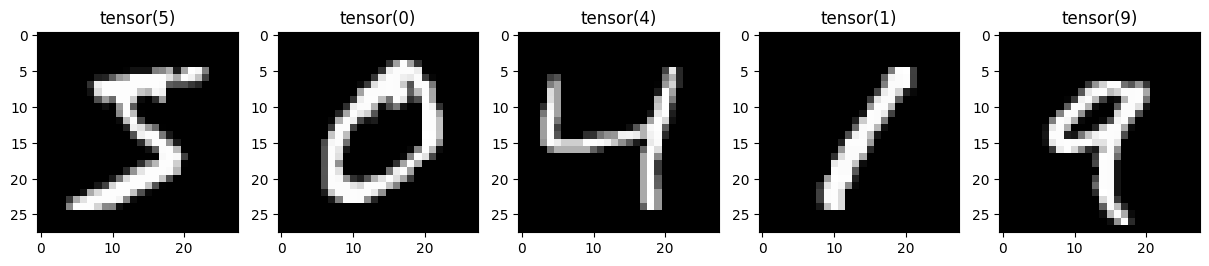

In [92]:
from torchvision.transforms import ToTensor, Compose
from torch import Tensor, tensor

def get_img_tfms(training: bool) -> Compose:
    """Return a composition of image transforms.

    Parameters
    ----------
    training : bool
        Are we training? If ``False``, we are validating.

    Returns
    -------
    Compose
        A composition of image transforms.

    """
    tfm_list: List[Callable] = [ToTensor(), lambda x: x.repeat(3, 1, 1)]

    if training is True:
        # tfm_list.append(???)
        pass

    return Compose(tfm_list)


def target_as_tensor(target_idx: int) -> Tensor:
    """Express the target as a ``torch.Tensor``.

    Parameters
    ----------
    target_idx : int
        The ground truth (i.e. the number shown in the image).

    Returns
    -------
    Tensor
        The target as a one-hot-encoded vector.

    """
    return tensor(target_idx)


train_set = MNIST(
    mnist_root,
    transform=get_img_tfms(training=True),
    target_transform=target_as_tensor,
    train=True,
)


valid_set = MNIST(
    mnist_root,
    transform=get_img_tfms(training=False),
    target_transform=target_as_tensor,
    train=False,
)

figure, axes = plt.subplots(1, 5, figsize=(15, 3))

for idx, axis in enumerate(axes.ravel()):

    image, target = train_set[idx]

    axis.imshow(image.permute(1, 2, 0), cmap="inferno")
    axis.set_title(target)



### Task 3: ``Dataset`` $\to$ ``DataLoader``

As before, wrap the ``Dataset``'s in ``DataLoader``s.

In [93]:
from torch.utils.data import DataLoader

batch_size = 64

### Task 4: Choose a model architecture

Torchvision provides a collection of models, [here](https://pytorch.org/vision/stable/models.html).

Since we are all on laptops, some of which don't have CUDA-enabled GPUs, I suggest we choose a modest neural network than won't melt any of our hardware. One such network, designed with mobile phones in mind, is [``MOBILENET``](https://pytorch.org/vision/stable/models/mobilenetv3.html).

#### Task 4 (a): instantiate the small one, and print it out.

Note:
- Torchvision's models can optionally be endowed with pretrained weights (from corresponding models pretrain on the ImageNet dataset).
- We can (optionally) supply these weights.
  - Using weights from a model, trained on one problem, as an intitial condition in another problem, is called transfer learning.
  - Why do you think this might be advantageous, even in disparate problems?

In [94]:
from torchvision.models import mobilenet_v3_small
from torchvision.models import MobileNet_V3_Small_Weights

model = mobilenet_v3_small(weights=MobileNet_V3_Small_Weights.DEFAULT)
print(model)

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), 

#### Task 4 (b): Uh oh, we've a problem.

- Look at the final linear layer.
  - How many output classes are there?
  - How many do we need?
- We need to "overload" the final layer to produce the correct number of output features for our problem. Fortunately this is easy.
- Uncomment the code below, choose the correct number of output features, and print the model again.

In [95]:
from torch.nn import Linear

# model.classifier[3] = Linear(model.classifier[3].in_features, ???)

### Task 5: Set up the remaining PyTorch bits and bobs

- We need to choose a loss function appropriate for classification.
  - Can you remember what we chose previously?
- We need an optimiser, too.
  - Remember our friend, Adam?
- Instantiate the model and loss function.

In [96]:
from torch.nn import BCELoss
from torch.optim import Adam

### Task 6: Set the device

We could have done this when we created the model, but it's fine here.

In [97]:
from torch.cuda import is_available

DEVICE = "cuda" if is_available() else "cpu"

# Note: here the return/assignment to ``_`` is just to supress the print.
# The model is moved onto the correct device in-place.
_ = model.to(DEVICE)

### Task 7: Writing our training and validation loops

As before, we need to write our training and validation loops.

- Complete the training loop
- Complete the validation loop

In [98]:
from typing import Dict

from torch import no_grad
from torch.nn import Module


def train_one_epoch(
    model: Module,
    train_loader: DataLoader,
    optimiser: Adam,
    loss_func: BCELoss,
) -> Dict[str, float]:
    """Train the model for a single epoch.

    Parameters
    ----------
    model : Module
        A neural network.
    train_loader : DataLoader
        The ``DataLoader`` for the training set.
    optimiser : Adam
        The optimiser to update the model's parameters with.
    loss_func : BCELoss
        Binary-cross-entropy loss function.

    Returns
    -------
    Dict[str, float]
        A dictionary of metrics.

    """
    model.train()


@no_grad()
def validate_one_epoch(
    model: Module,
    valid_loader: DataLoader,
    optimiser: Adam,
    loss_func: BCELoss,
) -> Dict[str, float]:
    """Train the model for a single epoch.

    Parameters
    ----------
    model : Module
        A neural network.
    valid_loader : DataLoader
        The ``DataLoader`` for the training set.
    loss_func : BCELoss
        Binary-cross-entropy loss function.

    Returns
    -------
    Dict[str, float]
        A dictionary of metrics.

    """
    model.eval()

### Task 8: Training and extracting metrics

- Now we can train our model for a specified number of epochs.
  - One epoch is where the model "sees" each training item once.
- Append the training and validation metrics to a list.
- Turm them into a ``pandas.DataFrame``
  - Note: You can turn a ``List[Dict[str, float]]``, say ``my_list`` into a ``DataFrame`` with ``DataFrame(my_list)``.

In [99]:
epochs = 3

for _ in range(epochs):
    pass

### Task 9: Plotting metrics

 - Let plots the training and validation metrics together

### Task 10: Visualising some predictions

Let's pick some random validation items, predict on them, and visualise the results.

In [100]:
valid_inds = [0, 666, 1024, 2048, 5555]

# Stick the model on the cpu
_ = model.to("cpu")
_ = model.eval()

# figure, axes = plt.subplots(1, len(valid_inds), figsize=(2 * len(valid_inds), 2))

# for idx, axis in zip(valid_inds, axes.ravel()):

#     img_tensor, _ = valid_set[idx]

#     print(img_tensor.shape)

#     with no_grad():
#         pred = model(img_tensor.unsqueeze(0)).softmax(dim=1).argmax(dim=1).item()


#     axis.imshow(img_tensor.permute(1, 2, 0))
#     axis.set_title(pred)


##